# This code takes in the results of the bivariate kernel density estimator of joint distribtuion on (b,q) and the univariate kernel density estimator of the strategy and uses them to produce a joint distribution of (c,q)

In [1]:
print("listing package versions... ")
import sys
print("python:", sys.version)
import pickle as pkl
import seaborn as sns
print("seaborn:", sns.__version__)
import matplotlib as mpl
import matplotlib.pyplot as plt
print("matplotlib:", mpl.__version__)
import numpy as np
print("numpy:", np.__version__)
import numba as nb
print("numba:", nb.__version__)
import scipy as sp
import scipy.integrate as sp1
import scipy.interpolate as sp2
import scipy.misc as sp3
import scipy.optimize as sp4
print("scipy:", sp.__version__)
import os
from pathlib import Path
%matplotlib inline

listing package versions... 
python: 3.7.0 (default, Jun 28 2018, 13:15:42) 
[GCC 7.2.0]
seaborn: 0.9.0
matplotlib: 2.2.3
numpy: 1.15.1
numba: 0.39.0
scipy: 1.1.0


In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

from matplotlib import rcParams
rcParams['figure.figsize'] = 8,8

sns.set_context("paper")
sns.set(font='serif')
sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]})

pardir=Path(os.getcwd()).parent.parent
datadir=str(pardir) +'/Data'

In [3]:
#industries: leg, mil, sci, edu, tec
industry='edu'
#weights: 55, 80
weight='55'
#fc is the scaling factor
fc=8

mydir=datadir+"/derive/"+industry+weight+"/"

# Download stuff

In [4]:
[PART,DATA]=pkl.load(open(datadir+'/derive/'+industry+weight+"j.pkl", "rb"))
sigma, haz=pkl.load(open(mydir+industry+weight+"j_strategy3_"+str(fc)+".pkl", "rb"))
reflect3=pkl.load(open(mydir+industry+weight+"j_reflect3_"+str(fc)+".pkl", "rb"))

mycmap=sns.cubehelix_palette(n_colors=50, start=1, rot=4, light=0.7, dark=0)

## This is our strategy (discrete arguments)

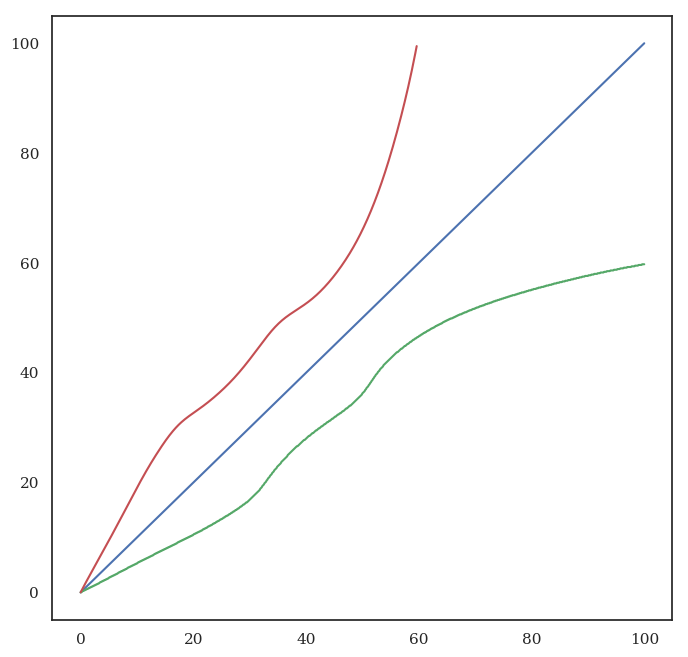

In [5]:
mprof=np.max(sigma)

plt.plot(np.divide(range(0,100*fc+1),fc), np.divide(range(0,100*fc+1),fc), '-', markersize=1,color= 'b')
plt.plot(np.divide(range(0,100*fc+1),fc), np.divide(sigma,fc), '-', markersize=1,color= 'g')
plt.plot(np.divide(range(0,mprof),fc), np.array(range(0,mprof))/fc+np.array(haz)[0:mprof], '-', markersize=1,color= 'r')

### I need to smooth the strategy and take it's derivative for the furure

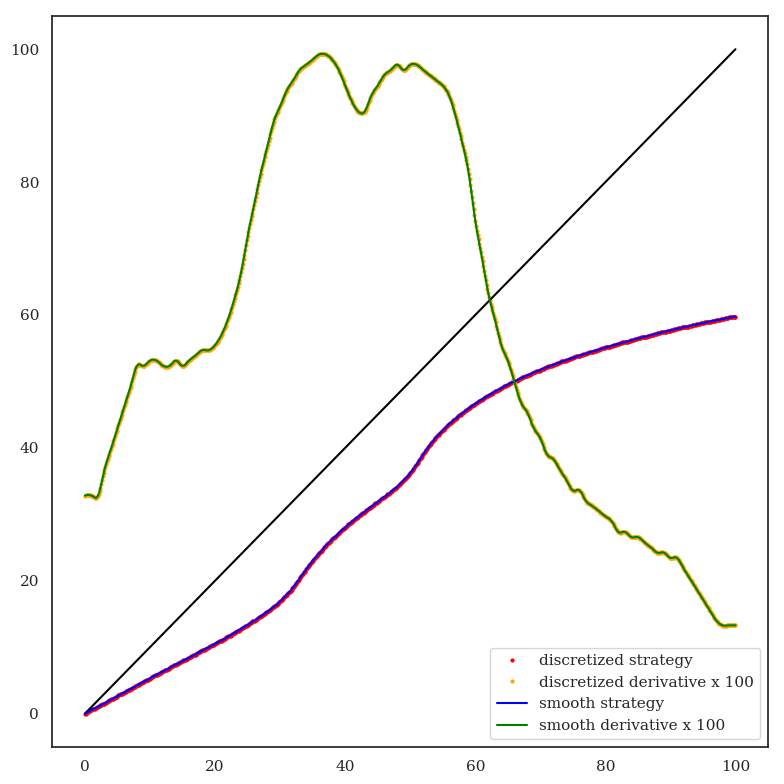

In [6]:
strat = sp2.interp1d(np.divide(range(0,100*fc+1),fc),np.divide(sigma,fc), kind='quadratic')

def strategy(x):
    return strat(max(0,min(100,x)))

arr=np.array(range(0,100*fc+1))
derivative = sp2.interp1d(arr,[sp3.derivative(strategy,min(max(fc/4,i),100-fc/4),dx=fc) for i in arr], kind='quadratic')

deriv=np.array([derivative(i/fc) for i in range(0,100*fc+1)])

arr=np.divide(range(0,100*fc+1),fc)
plt.plot(np.divide(range(0,100*fc+1),fc), np.divide(sigma,fc), 'ro', markersize=2,color= 'red', label='discretized strategy')
plt.plot(np.divide(range(0,100*fc+1),fc), 100*deriv, 'ro', markersize=2,color= 'orange', label='discretized derivative x 100')
plt.plot(np.divide(range(0,100*fc+1),fc), np.divide(range(0,100*fc+1),fc), '-', markersize=1,color= 'black')
plt.plot(arr, [strategy(i) for i in arr], '-', markersize=1.5,color= 'blue', label='smooth strategy')
plt.plot(arr, [100*derivative(i) for i in arr], '-', markersize=3,color= 'green', label='smooth derivative x 100')

plt.legend()
plt.tight_layout()

## This is our joint distribution of r-b and q

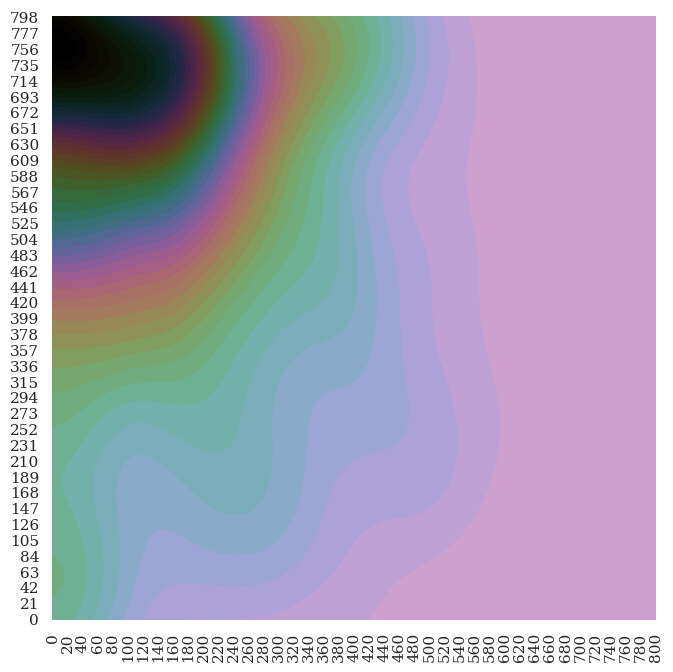

In [7]:
ax=sns.heatmap(reflect3, cmap=mycmap, cbar=0, square=1)
ax.invert_yaxis()

In [8]:
#I'll have to interpolate the distribution into the non-integer points

xx=np.array(list(range(0,100*fc+1)))
yy=np.array(list(range(0,100*fc+1)))

g = sp2.RectBivariateSpline(yy, xx, reflect3, kx=2, ky=2)
def gg(x,y):
    return g(x,y)[0,0]

### To get the distribution of q and types we need to apply the shading (shift the density to the right)
### Don't forget to multiply the density by the derivative of sigma (because of the jacobian)

In [9]:
# ww is the actual price weight, like 0.55 or 0.8
# this is the weight in the (1-w)*q+w*(r-b) formula
w=int(weight)/100
# this is the weight in the q+ww*(r-b) formula
ww=w/(1-w)
right=int(100*fc/(1-w))+1

reflect4=np.zeros((100*fc+1,right),dtype=float)
@nb.jit()
def create4(reflect3,reflect4): 
    for i in range(0,100*fc+1):
        for j in range(0,i+right-100*fc):
            der=deriv[int(round(j*(1-w)/fc))]
            score=sigma[int(round(j*(1-w)))]
            bid=(score-(1-w)*i)/w
            if bid<100*fc+1 and bid>-1:
                reflect4[i,j]=gg(i,bid)*der
create4(reflect3,reflect4)

## This is the density in the q and q+w(r-c)/(1-w) coordinates

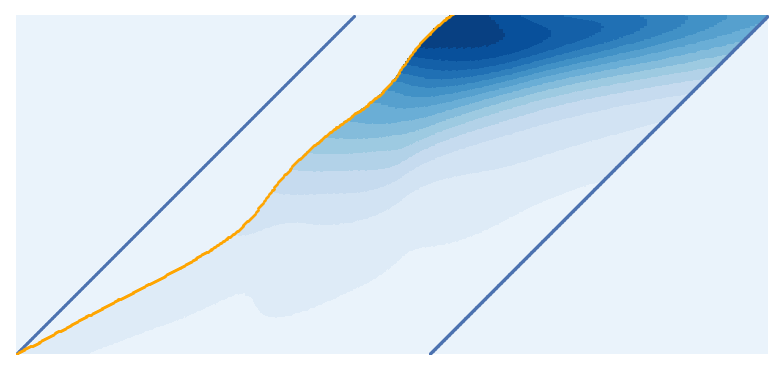

In [10]:
ax=sns.heatmap(reflect4, cmap=sns.color_palette("Blues",15), cbar=0, square=1)
ax.invert_yaxis()

plt.plot(range(0,int(100*fc)),np.array(range(0,int(100*fc))), 'ro', markersize=1, color= 'b')
plt.plot(100*fc*ww+np.array(range(0,int(100*fc))),np.array(range(0,int(100*fc))), 'ro', markersize=1, color= 'b')

plt.plot(np.array(range(0,100*fc+1))/(1-w),sigma/(1-w), 'ro', markersize=1, color= 'orange')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.tight_layout()

plt.savefig(industry+weight+'_beforeinterpolation.png', bbox_inches='tight')

In [11]:
#this is the first mass in the x axis
bounds1=np.zeros(100*fc+1, dtype=int)
for i in range(0,100*fc+1):
    j=0
    while j<right:
        if reflect4[i,j]>0:
            bounds1[i]=j
            j=right
        j+=1

In [12]:
#this is the last mass in the y axis
bounds2=np.zeros(right, dtype=int)
for j in range(0,right):
    i=100*fc
    while i>-1:
        if reflect4[i,j]>0:
            bounds2[j]=i
            i=-1
        i-=1

## Now let's interpolate

In [13]:
reflect5=reflect4
def create5(reflect4,reflect5): 
    for i in range(0,100*fc+1):
        for j in range(i,bounds1[i]):
            reflect5[i,j]=reflect4[i,bounds1[i]]
create5(reflect4,reflect5)
reflect5=(fc/(1-w))*(fc/(1-w))*reflect5/np.sum(reflect5)

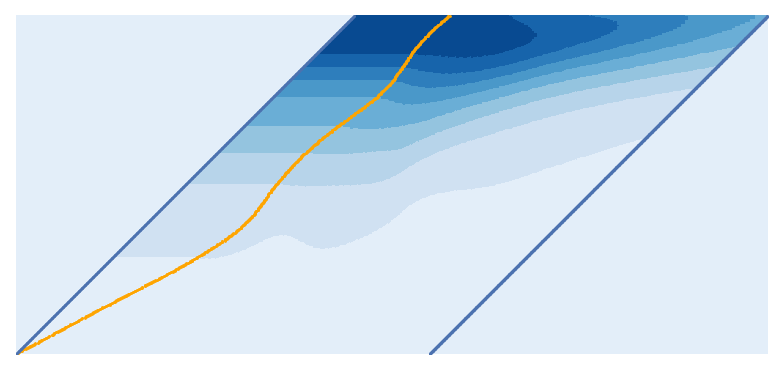

In [31]:
ax=sns.heatmap(reflect5, cmap=sns.color_palette("Blues",9), cbar=0, square=1)
ax.invert_yaxis()

#plt.plot(range(0,right),[bounds2[i] for i in range(0,right)],'s', markersize=1, color= 'red')
plt.plot([bounds1[i] for i in range(0,100*fc+1)],range(0,100*fc+1),'ro', markersize=1, color= 'orange')

plt.plot(range(0,int(100*fc)),np.array(range(0,int(100*fc))), 'ro', markersize=1, color= 'b')
plt.plot(100*fc*ww+np.array(range(0,int(100*fc))),np.array(range(0,int(100*fc))), 'ro', markersize=1, color= 'b')

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.savefig(datadir+"/derive/"+industry+weight+'_inter.png', bbox_inches='tight')

plt.savefig(industry+weight+'_afterinterpolation.png', bbox_inches='tight')

# In the end we need to check that the strategy performs reasonably well with this kind of interpolation...

In [15]:
Fp1=np.zeros((100*fc+1,right),dtype=float)
@nb.autojit(nopython=True)
def create1(f,Fp1):
    for i in range(0,100*fc+1):
        for j in range(0,right):
            Fp1[i,j]=(1-w)*np.sum(f[:i+1,j])/fc
            

Fp2=np.zeros((100*fc+1,right),dtype=float)
@nb.autojit(nopython=True)
def create2(f,Fp2): 
    for i in range(0,100*fc+1):
        for j in range(0,right):
            Fp2[i,j]=(1-w)*np.sum(f[i,:j+1])/fc
            
F=np.zeros((100*fc+1,right),dtype=float)
@nb.autojit(nopython=True)
def create0(Fp2,F):
    for i in range(0,100*fc+1):
        for j in range(0,right):
            F[i,j]=(1-w)*np.sum(Fp2[:i+1,j])/fc
    
#for simplicity    
Z=1

rhsfake=np.zeros((100*fc+1,right),dtype=float)
@nb.autojit(nopython=True)
def create3fake(F,Fp1,Fp2,rhs): 
    for i in range(0,100*fc+1):
        for j in range(i,right):
            if (j-i)!=0:
                den=-Fp2[i,j]+fc*Z*F[i,j]/((j-i)*(1-w))
                if den==0:
                    print(i,j)
                else:
                    my=Fp1[i,j]/den
                    if my>0:
                        rhs[i,j]=1
            rhs[0,0]=1/2
            rhs[0,1]=1/2
                            
rhs=np.zeros((100*fc+1,right),dtype=float)
@nb.autojit(nopython=True)
def create3(F,Fp1,Fp2,rhs): 
    for i in range(0,100*fc+1):
        for j in range(i,right):
            if (j-i)!=0:
                den=-Fp2[i,j]+fc*Z*F[i,j]/((j-i)*(1-w))
                if den==0:
                    print(i,j)
                else:
                    my=Fp1[i,j]/den
                    rhs[i,j]=my
            rhs[0,0]=1/2
            rhs[0,1]=1/2

In [16]:
create1(reflect5,Fp1)
create2(reflect5,Fp2)
create0(Fp2,F)
print('check that this is equal to 1: ',np.max(F))
create3fake(F,Fp1,Fp2,rhsfake)
create3(F,Fp1,Fp2,rhs)

check that this is equal to 1:  0.9999999999999996
0 1
0 1


In [17]:
# ax=sns.heatmap(rhsfake, cmap=mycmap, cbar=0, square=1)
# ax.invert_yaxis()
# plt.ylim(0, 100*fc+1)
# plt.xlim(0, 200*fc+1)
# plt.tight_layout()

In [18]:
gridz=rhs
xx=np.array(list(range(0,right)))
yy=np.array(list(range(0,100*fc+1)))

g = sp2.RectBivariateSpline(yy, xx, gridz, kx=2, ky=2)

def myfun(x,y):
    return g(y,x)

In [19]:
myode=sp1.ode(myfun, jac=None)
myode.set_initial_value(1*fc, 1*fc+1)
myode.set_integrator('dopri5')

dt=0.1
x=[0]
y=[0]
while myode.successful() and y[-1] < 100*fc  and x[-1] < right:
    x=x+[myode.t+dt]
    y=y+[myode.integrate(myode.t+dt)[0]]

# This is our anti-funnel, looks good enough (for Z=1)

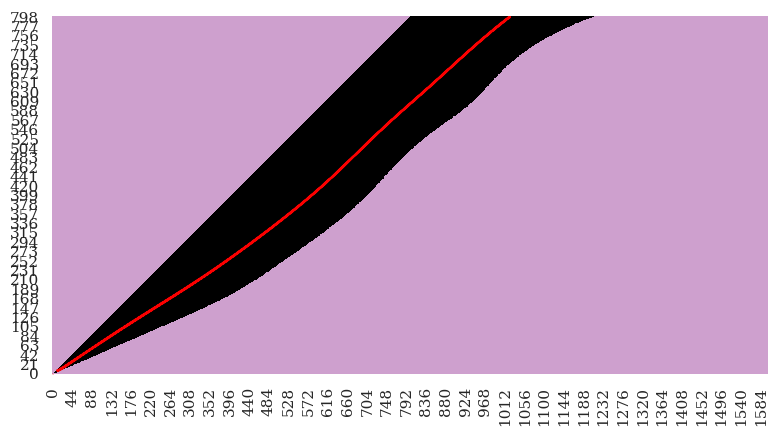

In [20]:
ax=sns.heatmap(rhsfake, cmap=mycmap, cbar=0, square=1)
ax.invert_yaxis()
plt.plot(np.array(x), np.array(y), 'ro', markersize=0.2, color= 'red')
#plt.plot([bounds1[i] for i in range(0,100*fc+1)],range(0,100*fc+1),'-', markersize=1, color= 'orange')
plt.ylim(0, 100*fc+1)
plt.xlim(0, 200*fc+1)

plt.tight_layout()
plt.savefig(datadir+"/derive/"+industry+weight+'_funnel.png', bbox_inches='tight')

In [21]:
#I'll have to interpolate the distribution into the non-integer points

xx=np.array(list(range(0,right)))
yy=np.array(list(range(0,100*fc+1)))

h = sp2.RectBivariateSpline(yy, xx, reflect5, kx=2, ky=2)
def hh(x,y):
    return h(x,y)[0,0]

In [22]:
reflect6=np.zeros((100*fc+1,100*fc+1),dtype=float)
@nb.jit()
def create6(reflect5,reflect6): 
    for i in range(0,100*fc+1):
        for j in range(0,100*fc+1):
            reflect6[i,j]=hh(i,i+j*ww)
create6(reflect5,reflect6)
reflect6=fc*fc*reflect6/np.sum(reflect6)

In [23]:
@nb.jit(nopython=True)
def K(band):
    return np.array([np.power(1-np.power((band-x)/band,2),3) for x in range(1,band+1)]
                    +[np.power(1-np.power(x/band,2),3) for x in range(1,band)], dtype=np.float64)*35/32

@nb.jit(nopython=True)
def smooth(reflect, reflect2, fc):
    myfc=3*fc
    Kband_ps=K(myfc)
    Kband_qs=K(myfc)
    bound1=100*fc+1
    bound2=100*fc+1
    for j in range(0,bound1):
        bot=max(0,j-myfc)
        top=min(j+myfc-1,100*fc+1)
        for i in range(0,bound2):
            area=0            
            left=max(i-myfc,0)
            right=min(i+myfc-1, 100*fc+1)
            for kj in range(bot,top):
                mykj=Kband_qs[kj-j+myfc]
                for ki in range(left,right):
                    myki=Kband_ps[ki-i+myfc]
                    my=myki*mykj
                    reflect2[j,i]+=reflect[kj,ki]*my
                    area+=my
            reflect2[j,i]=reflect2[j,i]/area
    return 0

reflect7=np.zeros(reflect6.shape)
smooth(reflect6,reflect7,fc)

0

# This is the joint distribution of r-c and q
# We will save it

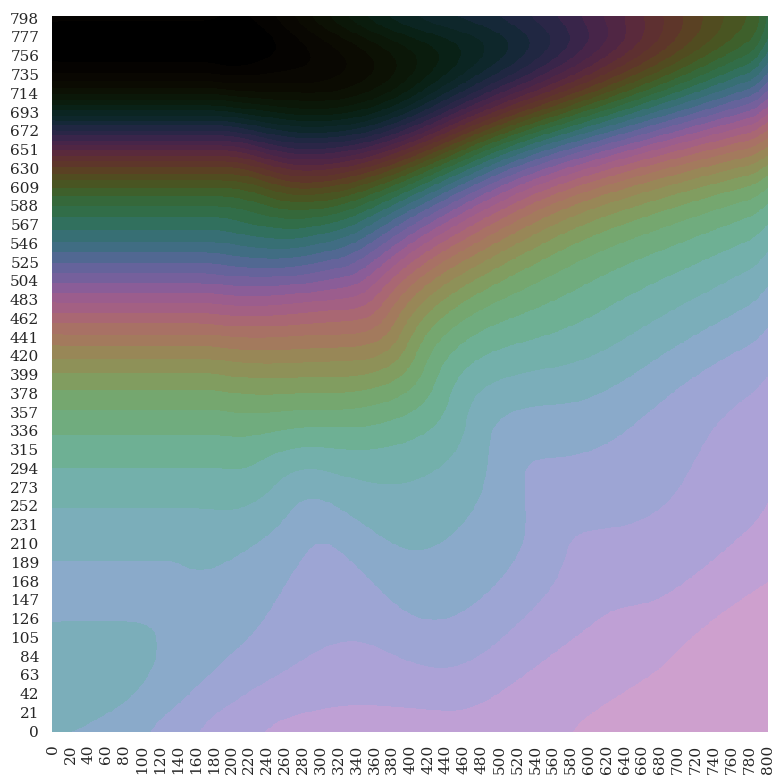

In [24]:
ax=sns.heatmap(reflect7, cmap=mycmap, cbar=0, square=1)
ax.invert_yaxis()

plt.tight_layout()

In [25]:
plt.savefig(datadir+"/derive/"+industry+weight+'_rmcq.png', bbox_inches='tight')

<Figure size 800x800 with 0 Axes>